## 线性回归模型

### 1. 线性回归模型原理

线性回归模型本质就是通过自变量的线性组合来描述因变量。

预测函数 $$ y_{pred} = XW $$

损失函数 $$ loss = \frac{1}{2}(y-y_{pred})^2 $$

我们的目的就是让loss最小。

### 2. 线性回归模型先验假设

1. 各自变量之间相互独立；
2. 因变量可以用自变量的线性组合来描述：   $ y_{pred} = XW + \epsilon  $；
3. 所有样本独立同分布(iid), 对于解释变量的所有观测值，随机误差项有相同的方差, 即随机误差项服从分布： $ \epsilon 服从 N(0,  \sigma ) $ ；
4. 回归模型中所有自变量与随机误差项不相关；
5. 随机误差项彼此不相关，即$cov(\epsilon_i, \epsilon_j) = 0$；
6. 解释变量是确定性变量，不是随机变量，与随机误差项彼此之间相互独立；
7. 解释变量之间不存在精确的（完全的）线性关系，即解释变量的样本观测值矩阵是满秩矩阵。

## 3.线性回归模型的求解

### 3.1 梯度下降

梯度下降是一种简单、经典的最优化方法，其在机器学习中被广泛的使用，其基本原理可以想象为一个下山问题，假如我站在一个山坡上，我想要下山，首先我会环视一周，看看哪个方向是下山最快的方向（最陡峭的方向），然后往前走一步，接下来继续环视一周，找到下降最快的方向，往前走一步，如此继续……直到走到山底。当然在梯度下降算法中，数学已经告诉我们了梯度就是loss下降最快的方向。 


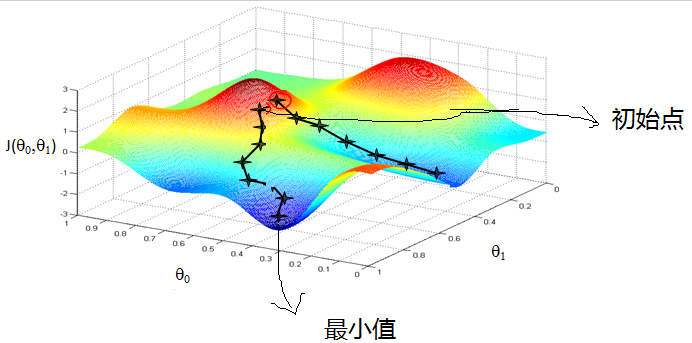

In [1]:
from IPython.display import display, Image
display(Image('gradient_descent.png'))

### 3.2 最小二乘法

用最小二乘法求解，不可避免的会出现求矩阵的逆矩阵，自然而然就引发了问题，因为矩阵的逆矩阵并不一定都会存在！求解矩阵的逆矩阵通常有三种方法。

#### 3.2.1 若$X^TX$可逆

损失函数 $$ loss = \frac{1}{2}(y-y_{pred})^2 = \frac{1}{2}(y-XW)^2 ,  $$
令loss关于W的导数等于0，就可以得到 $$ W = (X^TX)^{-1}X^Ty $$

#### 3.2.2 若$X^TX$不可逆
若$X^TX$不可逆，此时需要求解其广义逆，也叫伪逆，广义逆矩阵是逆矩阵的推广，因而逆矩阵满足的性质广义逆也满足，求解广义逆矩阵有以下两种方法：直接求解；SVD分解。下面详细介绍这两种方法的计算步骤。

① 直接求解：

求导，令导数为0，结果如下: $InvA=(X^TX)^{-1}X^T$


② 用SVD分解求解矩阵的伪逆

计算步骤：

(a). 先进行SVD分解，即$U, S, V = SVD(X^TX)$，其中分解得到的矩阵:U和V是正交阵，S是对角阵；

(b). 求解S的逆，注意这里S的逆矩阵也不一定存在，所以这里我求解的是S的伪逆阵；

(c). $svdInv(X^TX) = V  S^{-1}  U^T;$




Finding regularization constant using cross validation:
	Mean Squared Error: 0.00195801051297 (regularization: 0.0)
	Mean Squared Error: 0.00240037137306 (regularization: 0.01)
	Mean Squared Error: 0.00288141378151 (regularization: 0.02)
	Mean Squared Error: 0.0030842133535 (regularization: 0.03)
	Mean Squared Error: 0.00303210470568 (regularization: 0.04)
	Mean Squared Error: 0.0029074277234 (regularization: 0.05)
	Mean Squared Error: 0.00346493810974 (regularization: 0.06)
	Mean Squared Error: 0.00383274179378 (regularization: 0.07)
	Mean Squared Error: 0.00411214810959 (regularization: 0.08)
	Mean Squared Error: 0.00400044631257 (regularization: 0.09)
The best regularization factor: 0.000000
Mean squared error: 0.00195801051297 (given by reg. factor: 0.0)


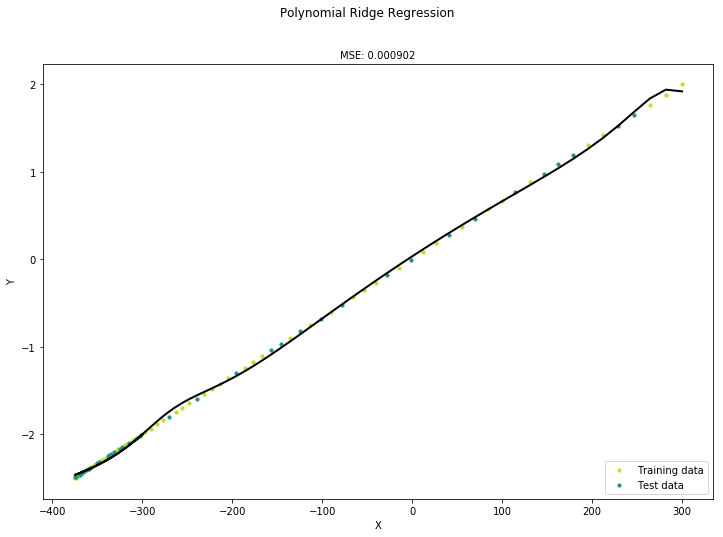

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations_with_replacement
import sys
import os
import math


def shuffle_data(X, y, seed=None):
    if seed:
        np.random.seed(seed)

    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    
    return X[idx], y[idx]


# k-folds交叉验证
def k_folds_cross_validation(X, y, k, shuffle=True):
    
    if shuffle:
        X, y = shuffle_data(X, y)
    
    n_samples, n_features = X.shape
    redundancy_samples = {}
    n_redundancy_samples = n_samples%k
    if n_redundancy_samples:
        redundancy_samples['X'] = X[-n_redundancy_samples:]
        redundancy_samples['y'] = y[-n_redundancy_samples:]
        X = X[:-n_redundancy_samples]
        y = y[:-n_redundancy_samples]
        
    X_split = np.split(X, k)
    y_split = np.split(y, k)
    
    datasets = []
    for i in range(k):
        X_test = X_split[i]
        y_test = y_split[i]
        X_train = np.concatenate(X_split[:i] + X_split[i+1:], axis=0)
        y_train = np.concatenate(y_split[:i] + y_split[i+1:], axis=0)
        datasets.append([X_train, X_test, y_train, y_test])
    
    # 将多余的样本添加到被划分后的所有训练集中
    if n_redundancy_samples:
        for i in range(k):
            datasets[i][0] = np.concatenate([datasets[i][0], redundancy_samples['X']], axis=0)
            datasets[i][2] = np.concatenate([datasets[i][2], redundancy_samples['y']], axis=0)
    return np.array(datasets)




# 正规化数据集 X
def normalize(X, axis=-1, p=2):
    lp_norm = np.atleast_1d(np.linalg.norm(X, p, axis))
    lp_norm[lp_norm == 0] = 1
    return X / np.expand_dims(lp_norm, axis)


# 标准化数据集 X
def standardize(X):
    X_std = np.zeros(X.shape)
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    
    # 做除法运算时请永远记住分母不能等于0的情形
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0) 
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    
    return X_std


# 划分数据集为训练集和测试集
def train_test_split(X, y, test_size=0.2, shuffle=True, seed=None):
    if shuffle:
        X, y = shuffle_data(X, y, seed)
        
    n_train_samples = int(X.shape[0] * (1-test_size))
    x_train, x_test = X[:n_train_samples], X[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test


def polynomial_features(X, degree):
    X = X.reshape(X.shape[0], -1)
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new

# 计算均方误差MSE
def mean_squared_error(y_true, y_pred):
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse


# 定义Base regression model
class Regression(object):
    """ Base regression model. 
    Parameters:
    -----------
    reg_factor: float
        正则化系数. 
    n_iterations: float
        迭代次数.
    learning_rate: float
        学习率, 反应了梯度下降更新参数w的快慢, 学习率越大学习的越快, 但是可能导致模型不收敛, 学习率越小学习的越慢.
    gradient_descent: boolean
        是否使用梯度下降方法求解参数w，如果gradient_descent=True, 则用gradient_descent学习参数w; 
        否则用广义最小二乘法直接求解参数w.
    """
    def __init__(self, reg_factor, n_iterations, learning_rate, gradient_descent):
        self.w = None
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.gradient_descent = gradient_descent
        self.reg_factor = reg_factor

    def fit(self, X, y):
        # 在第一列添加偏置列，全部初始化为1
        X = np.insert(X, 0, 1, axis=1)
        
        # 注意维度的一致性，Andrew Ng说永远也不要羞于使用reshape
        X = X.reshape(X.shape[0], -1)
        y = y.reshape(y.shape[0], -1)

        n_features = np.shape(X)[1]

        # 梯度下降更新参数w.
        if self.gradient_descent:
            # 参数初始化 [-1/n_features, 1/n_features]
            limit = 1 / np.sqrt(n_features)
            self.w = np.random.uniform(-limit, limit, (n_features, 1))
            # 每迭代一次更新一次参数w
            for _ in range(self.n_iterations):
                y_pred = X.dot(self.w)
                
                # L2正则化损失函数loss关于参数w的梯度
                grad_w = X.T.dot(- (y - y_pred)) + self.reg_factor * self.w
                # 更新参数w
                self.w -= self.learning_rate * grad_w
        # Get weights by least squares (by pseudoinverse)
        else:
            U, S, V = np.linalg.svd(
                X.T.dot(X) + self.reg_factor * np.identity(n_features))
            S = np.diag(S)
            X_sq_reg_inv = V.dot(np.linalg.pinv(S)).dot(U.T)
            self.w = X_sq_reg_inv.dot(X.T).dot(y)

    def predict(self, X):
        # 训练模型的时候我们添加了偏置，预测的时候也需要添加偏置
        X = np.insert(X, 0, 1, axis=1)
        X = X.reshape(X.shape[0], -1)
        y_pred = X.dot(self.w)
        return y_pred


class LinearRegression(Regression):
    """线性回归模型.
    Parameters:
    -----------
    n_iterations: float
        迭代次数.
    learning_rate: float
        学习率.
    gradient_descent: boolean
        是否使用梯度下降方法求解参数w，如果gradient_descent=True, 则用gradient_descent学习参数w; 
        否则用广义最小二乘法直接求解参数w.
    """
    def __init__(self, n_iterations=1000, learning_rate=0.001, gradient_descent=True):
        super(LinearRegression, self).__init__(reg_factor=0, n_iterations=n_iterations, 
                                               learning_rate=learning_rate, 
                                               gradient_descent=gradient_descent)

class PolynomialRegression(Regression):
    """多项式回归模型.
    Parameters:
    -----------
    degree: int
        数据集X中特征变换的阶数.
    n_iterations: float
        迭代次数.
    learning_rate: float
        学习率.
    gradient_descent: boolean
        是否使用梯度下降方法求解参数w，如果gradient_descent=True, 则用gradient_descent学习参数w; 
        否则用广义最小二乘法直接求解参数w.
    """
    def __init__(self, degree, n_iterations=1000, learning_rate=0.001, gradient_descent=True):
        self.degree = degree
        super(PolynomialRegression, self).__init__(reg_factor=0, n_iterations=n_iterations, 
                                                   learning_rate=learning_rate, 
                                                   gradient_descent=gradient_descent)

    def fit(self, X, y):
        X_transformed = polynomial_features(X, degree=self.degree)
        super(PolynomialRegression, self).fit(X_transformed, y)
        
    def predict(self, X):
        X_transformed = polynomial_features(X, degree=self.degree)
        return super(PolynomialRegression, self).predict(X_transformed)

class RidgeRegression(Regression):
    """loss = (1/2) * (y - y_pred)^2 + reg_factor * w^2. 正则化项可以减少模型模型的方差.
    Parameters:
    -----------
    reg_factor: float
        regularization factor. feature shrinkage and decrease variance. 
    n_iterations: float
        迭代次数.
    learning_rate: float
        学习率.
    gradient_descent: boolean
        是否使用梯度下降方法求解参数w，如果gradient_descent=True, 则用gradient_descent学习参数w; 
        否则用广义最小二乘法直接求解参数w.
    """
    def __init__(self, reg_factor, n_iterations=1000, learning_rate=0.001, gradient_descent=True):
        super(RidgeRegression, self).__init__(reg_factor, n_iterations, learning_rate, gradient_descent)

class PolynomialRidgeRegression(Regression):
    """除了做一个特征多项式转换，其它的与岭回归一样.
    Parameters:
    -----------
    degree: int
        数据集X中特征变换的阶数.
    reg_factor: float
        正则化因子. 
    n_iterations: float
        迭代次数.
    learning_rate: float
        学习率.
    gradient_descent: boolean
        是否使用梯度下降方法求解参数w，如果gradient_descent=True, 则用gradient_descent学习参数w; 
        否则用广义最小二乘法直接求解参数w.
    """
    def __init__(self, degree, reg_factor, n_iterations=1000, learning_rate=0.01, gradient_descent=True):
        self.degree = degree
        super(PolynomialRidgeRegression, self).__init__(reg_factor, n_iterations, learning_rate, gradient_descent)
        
    def fit(self, X, y):
        
        X_transformed = normalize(polynomial_features(X, degree=self.degree))
        super(PolynomialRidgeRegression, self).fit(X_transformed, y)

    def predict(self, X):
        X_transformed = normalize(polynomial_features(X, degree=self.degree))
        return super(PolynomialRidgeRegression, self).predict(X_transformed)


def main():

    def generage_data(n_samples):
        X = np.linspace(-1, 1, n_samples) + np.linspace(-1, 1, n_samples)**2 - 1
        X = X.reshape(X.shape[0], -1)
        y = 2 * X + np.random.uniform(0, 0.01, n_samples).reshape(n_samples, -1)
        y = y.reshape(n_samples, -1)
        return X, y
    
    X, y = generage_data(100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    poly_degree = 15

    # 用k折交叉验证寻找最佳的正则化因子
    lowest_error = float("inf")
    best_reg_factor = None
    print ("Finding regularization constant using cross validation:")
    k = 10
    for reg_factor in np.arange(0, 0.1, 0.01):
        cross_validation_datasets = k_folds_cross_validation(X_train, y_train, k=k)
        
        mse = 0
        for _X_train, _X_test, _y_train, _y_test in cross_validation_datasets:
            clf = PolynomialRidgeRegression(degree=poly_degree, 
                                            reg_factor=reg_factor,
                                            learning_rate=0.001,
                                            n_iterations=10000)
            clf.fit(_X_train, _y_train)
            y_pred = clf.predict(_X_test)
            _mse = mean_squared_error(_y_test, y_pred)
            mse += _mse
        mse /= k

        # Print the mean squared error
        print ("\tMean Squared Error: %s (regularization: %s)" % (mse, reg_factor))

        # Save regularization factor that gave lowest error
        if mse < lowest_error:
            best_reg_factor = reg_factor
            lowest_error = mse
            
    print('The best regularization factor: %f'%best_reg_factor)

    # 用找到的最佳正则化因子训练模型
    clf = PolynomialRidgeRegression(degree=poly_degree, 
                                    reg_factor=best_reg_factor,
                                    learning_rate=0.001,
                                    n_iterations=10000)
    clf.fit(X_train, y_train)
    
    # 用训练好的模型在测试集上预测
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print ("Mean squared error: %s (given by reg. factor: %s)" % (lowest_error, best_reg_factor))
    
    # 用训练好的模型在整个数据集上预测
    y_pred_all = clf.predict(X)

    # Color map
    cmap = plt.get_cmap('viridis')

    # Plot the results
    plt.figure(figsize=(12, 8))
    m1 = plt.scatter(300 * X_train, y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(300 * X_test, y_test, color=cmap(0.5), s=10)
    plt.plot(300 * X, y_pred_all, color='black', linewidth=2, label="Prediction")
    plt.suptitle("Polynomial Ridge Regression")
    plt.title("MSE: %.6f" % mse, fontsize=10)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
    plt.show()

if __name__ == "__main__":
    main()